#Install Libraries

In [1]:
#NLTK libraries to remove stopwords, for lemmatization and tokenizing
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

#Import Libraries

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re

In [3]:
from tabulate import tabulate

In [4]:
from wordcloud import WordCloud, STOPWORDS

In [5]:
from keras.preprocessing.text import Tokenizer
from keras.layers import Embedding
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras import layers
from keras import regularizers
from keras import backend as K
from keras.callbacks import ModelCheckpoint

In [6]:
from scipy import stats

In [7]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

In [8]:
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [9]:
import gensim
from gensim.models import Word2Vec

#Load Data

In [10]:
#Mounting Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [11]:
#Loading the training set
train_read=pd.read_csv("/content/gdrive/MyDrive/EmoInt/joy/train_joy.txt",delimiter = "\t",names=["Index", "Tweet", "Emotion", "Emotion Intensity"])

In [12]:
#Loading the development set
dev_read=pd.read_csv("/content/gdrive/MyDrive/EmoInt/joy/dev_joy_intensity.txt",delimiter = "\t",names=["Index", "Tweet", "Emotion", "Emotion Intensity"])

In [13]:
#Loading the test set
test_read=pd.read_csv("/content/gdrive/MyDrive/EmoInt/joy/test_joy_intensity.txt",delimiter = "\t",names=["Index", "Tweet", "Emotion", "Emotion Intensity"])

In [14]:
#Display the training data for anger 
train_read.head()

,Index,Tweet,Emotion,Emotion Intensity
0,30000,Just got back from seeing @GaryDelaney in Burs...,joy,0.980
1,30001,Oh dear an evening of absolute hilarity I don'...,joy,0.958
2,30002,Been waiting all week for this game â¤ï¸â¤ï...,joy,0.940
3,30003,"@gardiner_love : Thank you so much, Gloria! Yo...",joy,0.938
4,30004,I feel so blessed to work with the family that...,joy,0.938


In [15]:
#Display the development data for anger 
dev_read.head()

,Index,Tweet,Emotion,Emotion Intensity
0,30823,"@theclobra lol I thought maybe, couldn't decid...",joy,0.312
1,30824,Nawaz Sharif is getting more funnier than @kap...,joy,0.700
2,30825,Nawaz Sharif is getting more funnier than @kap...,joy,0.580
3,30826,@tomderivan73 ðŸ˜...I'll just people watch an...,joy,0.438
4,30827,I love my family so much #lucky #grateful #sma...,joy,0.936


In [16]:
#Display the test data for anger 
test_read.head()

,Index,Tweet,Emotion,Emotion Intensity
0,30902,You must be knowing #blithe means (adj.) Happ...,joy,0.583
1,30903,Old saying 'A #smile shared is one gained for ...,joy,0.500
2,30904,Bridget Jones' Baby was bloody hilarious ðŸ˜… ...,joy,0.860
3,30905,@Elaminova sparkling water makes your life spa...,joy,0.521
4,30906,I'm tired of everybody telling me to chill out...,joy,0.042


#Data Analysis

In [17]:
#Length of training set
train_read.shape[0]

823

In [18]:
#Length of development set
dev_read.shape[0]

79

In [19]:
#Length of test set
test_read.shape[0]

714

In [20]:
#Data type of each column in training set
train_read.dtypes

Index                  int64
Tweet                 object
Emotion               object
Emotion Intensity    float64
dtype: object

In [21]:
#Converting tweet and emotion from object to string type
train_read.astype({'Tweet':'string', 'Emotion':'string'}).dtypes

Index                  int64
Tweet                 string
Emotion               string
Emotion Intensity    float64
dtype: object

In [22]:
#Describe the dataset
train_read.describe()

,Index,Emotion Intensity
count,823.00000,823.000000
mean,30411.00000,0.492618
std,237.72393,0.204334
min,30000.00000,0.019000
25%,30205.50000,0.340000
50%,30411.00000,0.480000
75%,30616.50000,0.646000
max,30822.00000,0.980000


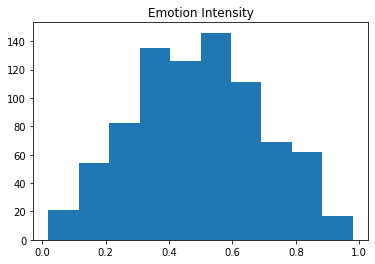

In [23]:
hist = train_read.hist(column='Emotion Intensity',grid=False)

#Text Cleaning

## Converting to Lower Case

In [24]:
train_read['Cleaned Text']=train_read['Tweet'].str.lower()

In [25]:
train_read.head()

,Index,Tweet,Emotion,Emotion Intensity,Cleaned Text
0,30000,Just got back from seeing @GaryDelaney in Burs...,joy,0.980,just got back from seeing @garydelaney in burs...
1,30001,Oh dear an evening of absolute hilarity I don'...,joy,0.958,oh dear an evening of absolute hilarity i don'...
2,30002,Been waiting all week for this game â¤ï¸â¤ï...,joy,0.940,been waiting all week for this game â¤ï¸â¤ï...
3,30003,"@gardiner_love : Thank you so much, Gloria! Yo...",joy,0.938,"@gardiner_love : thank you so much, gloria! yo..."
4,30004,I feel so blessed to work with the family that...,joy,0.938,i feel so blessed to work with the family that...


In [26]:
dev_read['Cleaned Text']=dev_read['Tweet'].str.lower()

In [27]:
test_read['Cleaned Text']=test_read['Tweet'].str.lower()

## Removing Numbers

In [28]:
train_read['Tweet'][33]

"This is the day You've made, \\n\\nLet us rehoi rejoice and be glad with all that I am. \\n\\nðŸ˜ŠðŸ’–\\n\\n#aja \\nGood morning!!!!"

In [29]:
train_read['Cleaned Text'].replace('\d+', '', regex=True, inplace=True)

In [30]:
train_read['Cleaned Text'][33]

"this is the day you've made, \\n\\nlet us rehoi rejoice and be glad with all that i am. \\n\\nðÿ˜šðÿ’–\\n\\n#aja \\ngood morning!!!!"

In [31]:
dev_read['Cleaned Text'].replace('\d+', '', regex=True, inplace=True)

In [32]:
test_read['Cleaned Text'].replace('\d+', '', regex=True, inplace=True)

## Removing URLs

In [33]:
train_read['Cleaned Text'] = train_read['Cleaned Text'].str.replace('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', ' ')

In [34]:
dev_read['Cleaned Text'] = dev_read['Cleaned Text'].str.replace('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', ' ')

In [35]:
test_read['Cleaned Text'] = test_read['Cleaned Text'].str.replace('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', ' ')

## Separating Hashtags

In [36]:
train_read['Tweet'][3]

"@gardiner_love : Thank you so much, Gloria! You're so sweet, and thoughtful! You just made my day more joyful! I love you too! ðŸ˜ŠðŸ’•"

In [37]:
def separating_hashtags(text):
  return re.findall("#([a-zA-Z0-9_]{1,50})", text)

In [38]:
def removing_hashtags(text):
  return re.sub("#[A-Za-z0-9_]+","", text)

In [39]:
train_read['Hashtags'] = train_read['Tweet'].apply(separating_hashtags)
train_read['Cleaned Text'] = train_read['Cleaned Text'].apply(removing_hashtags)

In [40]:
train_read['Cleaned Text'][3]

"@gardiner_love : thank you so much, gloria! you're so sweet, and thoughtful! you just made my day more joyful! i love you too! ðÿ˜šðÿ’•"

In [41]:
train_read['Hashtags'][3]

[]

In [42]:
dev_read['Hashtags'] = dev_read['Tweet'].apply(separating_hashtags)
dev_read['Cleaned Text'] = dev_read['Cleaned Text'].apply(removing_hashtags)

In [43]:
test_read['Hashtags'] = test_read['Tweet'].apply(separating_hashtags)
test_read['Cleaned Text'] = test_read['Cleaned Text'].apply(removing_hashtags)

## Removing UserHandles




In [44]:
train_read['Tweet'][16]

"@WyoWiseGuy @LivingVertical however, REI did offer me the job today as well. Can't believe how exponentially freaking joyous I feel...!!!"

In [45]:
def removeUserHandles(text):
  return re.sub("@[A-Za-z0-9_]+","", text)

In [46]:
train_read['Cleaned Text'] = train_read['Cleaned Text'].apply(removeUserHandles)

In [47]:
train_read['Cleaned Text'][16]

"  however, rei did offer me the job today as well. can't believe how exponentially freaking joyous i feel...!!!"

In [48]:
dev_read['Cleaned Text'] = dev_read['Cleaned Text'].apply(removeUserHandles)

In [49]:
test_read['Cleaned Text'] = test_read['Cleaned Text'].apply(removeUserHandles)

##Removing Special Characters

In [50]:
train_read['Tweet'][27]

'Morning all! Of course it is sunny on this Monday morning to cheerfully welcome us back to work.:)'

In [51]:
def remove_specialCharacters(text):
  return re.sub(r"[^\*a-zA-Z0-9]"," ",text)

In [52]:
train_read['Cleaned Text'] = train_read['Cleaned Text'].apply(remove_specialCharacters)

In [53]:
train_read['Cleaned Text'][27]

'morning all  of course it is sunny on this monday morning to cheerfully welcome us back to work   '

In [54]:
dev_read['Cleaned Text'] = dev_read['Cleaned Text'].apply(remove_specialCharacters)

In [55]:
test_read['Cleaned Text'] = test_read['Cleaned Text'].apply(remove_specialCharacters)

## Tokenizing

In [56]:
def tokenize(text):
  return word_tokenize(text)

In [57]:
train_read['Cleaned Text'] = train_read['Cleaned Text'].apply(tokenize)

In [58]:
train_read.head()

,Index,Tweet,Emotion,Emotion Intensity,Cleaned Text,Hashtags
0,30000,Just got back from seeing @GaryDelaney in Burs...,joy,0.980,"[just, got, back, from, seeing, in, burslem, a...",[hilarious]
1,30001,Oh dear an evening of absolute hilarity I don'...,joy,0.958,"[oh, dear, an, evening, of, absolute, hilarity...",[]
2,30002,Been waiting all week for this game â¤ï¸â¤ï...,joy,0.940,"[been, waiting, all, week, for, this, game]","[cheer, friday]"
3,30003,"@gardiner_love : Thank you so much, Gloria! Yo...",joy,0.938,"[thank, you, so, much, gloria, you, re, so, sw...",[]
4,30004,I feel so blessed to work with the family that...,joy,0.938,"[i, feel, so, blessed, to, work, with, the, fa...",[]


In [59]:
dev_read['Cleaned Text'] = dev_read['Cleaned Text'].apply(tokenize)

In [60]:
test_read['Cleaned Text'] = test_read['Cleaned Text'].apply(tokenize)

## Remove Stopwords

In [61]:
stop_words = set(stopwords.words('english'))

In [62]:
def remove_stopwords(word_list):
  return [word for word in word_list if word not in stopwords.words('english')]

In [63]:
train_read['Cleaned Text'] = train_read['Cleaned Text'].apply(remove_stopwords)

In [64]:
train_read.head()

,Index,Tweet,Emotion,Emotion Intensity,Cleaned Text,Hashtags
0,30000,Just got back from seeing @GaryDelaney in Burs...,joy,0.980,"[got, back, seeing, burslem, amazing, face, st...",[hilarious]
1,30001,Oh dear an evening of absolute hilarity I don'...,joy,0.958,"[oh, dear, evening, absolute, hilarity, think,...",[]
2,30002,Been waiting all week for this game â¤ï¸â¤ï...,joy,0.940,"[waiting, week, game]","[cheer, friday]"
3,30003,"@gardiner_love : Thank you so much, Gloria! Yo...",joy,0.938,"[thank, much, gloria, sweet, thoughtful, made,...",[]
4,30004,I feel so blessed to work with the family that...,joy,0.938,"[feel, blessed, work, family, nanny, nothing, ...",[]


In [65]:
dev_read['Cleaned Text'] = dev_read['Cleaned Text'].apply(remove_stopwords)

In [66]:
test_read['Cleaned Text'] = test_read['Cleaned Text'].apply(remove_stopwords)

##Lemmatization

In [67]:
lemmatizer = WordNetLemmatizer()

In [68]:
def lemmatize(word_list):
  lemmatized_output = ' '.join([lemmatizer.lemmatize(w, pos = "v") for w in word_list])
  return nltk.word_tokenize(lemmatized_output)

In [69]:
train_read['Cleaned Text'] = train_read['Cleaned Text'].apply(lemmatize)

In [70]:
train_read.head()

,Index,Tweet,Emotion,Emotion Intensity,Cleaned Text,Hashtags
0,30000,Just got back from seeing @GaryDelaney in Burs...,joy,0.980,"[get, back, see, burslem, amaze, face, still, ...",[hilarious]
1,30001,Oh dear an evening of absolute hilarity I don'...,joy,0.958,"[oh, dear, even, absolute, hilarity, think, la...",[]
2,30002,Been waiting all week for this game â¤ï¸â¤ï...,joy,0.940,"[wait, week, game]","[cheer, friday]"
3,30003,"@gardiner_love : Thank you so much, Gloria! Yo...",joy,0.938,"[thank, much, gloria, sweet, thoughtful, make,...",[]
4,30004,I feel so blessed to work with the family that...,joy,0.938,"[feel, bless, work, family, nanny, nothing, lo...",[]


In [71]:
dev_read['Cleaned Text'] = dev_read['Cleaned Text'].apply(lemmatize)

In [72]:
test_read['Cleaned Text'] = test_read['Cleaned Text'].apply(lemmatize)

## Word Cloud

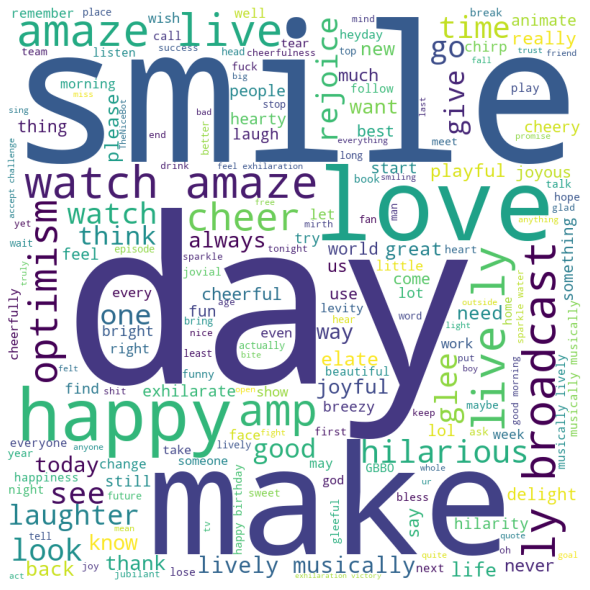

In [73]:
comment_words = ''
for val in train_read['Cleaned Text']:
    comment_words += " ".join(val)+" "

for val in train_read['Hashtags']:
    comment_words += " ".join(val)+" "

wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                min_font_size = 10).generate(comment_words)
 
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

In [74]:
#Unique words in Train set
len(comment_words)
li = list(comment_words.split(" "))
x=np.array(li)
max_words=len(np.unique(x))

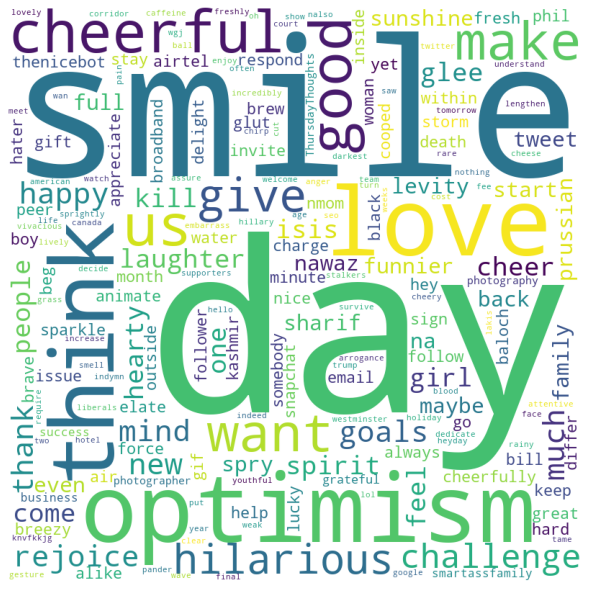

In [75]:
comment_words = ''
for val in dev_read['Cleaned Text']:
    comment_words += " ".join(val)+" "

for val in dev_read['Hashtags']:
    comment_words += " ".join(val)+" "

wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                min_font_size = 10).generate(comment_words)
 
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

In [76]:
#Unique words in Dev set
len(comment_words)
li = list(comment_words.split(" "))
x=np.array(li)
len(np.unique(x))

439

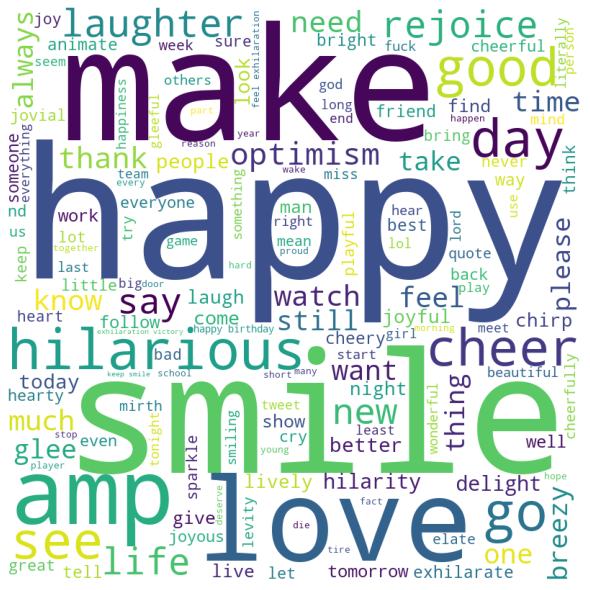

In [77]:
comment_words = ''
for val in test_read['Cleaned Text']:
    comment_words += " ".join(val)+" "

for val in test_read['Hashtags']:
    comment_words += " ".join(val)+" "

wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                min_font_size = 10).generate(comment_words)
 
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

In [78]:
#Unique words in Test set
len(comment_words)
li = list(comment_words.split(" "))
x=np.array(li)
len(np.unique(x))

2334

# Text Pre-processing

In [79]:
def join_sent(text):  
    str1 = " "
    return str1.join(text)

In [80]:
train_read['Tweet text']=train_read['Cleaned Text']+train_read['Hashtags']

In [81]:
dev_read['Tweet text']=dev_read['Cleaned Text']+dev_read['Hashtags']

In [82]:
test_read['Tweet text']=test_read['Cleaned Text']+test_read['Hashtags']

In [83]:
train_read['Sentences']=train_read['Tweet text'].apply(join_sent)

In [84]:
train_read.head()

,Index,Tweet,Emotion,Emotion Intensity,Cleaned Text,Hashtags,Tweet text,Sentences
0,30000,Just got back from seeing @GaryDelaney in Burs...,joy,0.980,"[get, back, see, burslem, amaze, face, still, ...",[hilarious],"[get, back, see, burslem, amaze, face, still, ...",get back see burslem amaze face still hurt lau...
1,30001,Oh dear an evening of absolute hilarity I don'...,joy,0.958,"[oh, dear, even, absolute, hilarity, think, la...",[],"[oh, dear, even, absolute, hilarity, think, la...",oh dear even absolute hilarity think laugh muc...
2,30002,Been waiting all week for this game â¤ï¸â¤ï...,joy,0.940,"[wait, week, game]","[cheer, friday]","[wait, week, game, cheer, friday]",wait week game cheer friday
3,30003,"@gardiner_love : Thank you so much, Gloria! Yo...",joy,0.938,"[thank, much, gloria, sweet, thoughtful, make,...",[],"[thank, much, gloria, sweet, thoughtful, make,...",thank much gloria sweet thoughtful make day jo...
4,30004,I feel so blessed to work with the family that...,joy,0.938,"[feel, bless, work, family, nanny, nothing, lo...",[],"[feel, bless, work, family, nanny, nothing, lo...",feel bless work family nanny nothing love amp ...


In [85]:
dev_read['Sentences']=dev_read['Tweet text'].apply(join_sent)

In [86]:
test_read['Sentences']=test_read['Tweet text'].apply(join_sent)

In [87]:
def max_len_sent():
  max=0
  for i in train_read['Tweet text']:
    if len(i)>max:
      max=len(i)
  return max

max_len_train=max_len_sent()
max_len_train

20

In [88]:
def max_len_sent():
  max=0
  for i in dev_read['Tweet text']:
    if len(i)>max:
      max=len(i)
  return max

max_len_dev=max_len_sent()
max_len_dev

19

In [89]:
def max_len_sent():
  max=0
  for i in test_read['Tweet text']:
    if len(i)>max:
      max=len(i)
  return max

max_len_test=max_len_sent()
max_len_test

21

In [90]:
train_read_5 = train_read[train_read['Emotion Intensity'] > 0.5]

In [91]:
dev_read_5 = dev_read[dev_read['Emotion Intensity'] > 0.5]

In [92]:
#test_read_5 = test_read[test_read['Emotion Intensity'] > 0.5]

In [93]:
data_to_list = train_read['Sentences'].values.tolist()
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(data_to_list)
sequences = tokenizer.texts_to_sequences(data_to_list)
train_data = pad_sequences(sequences, maxlen=max_len_train)
print(train_data)

[[   0    0    0 ...   70   49   21]
 [   0    0    0 ...   49  140   22]
 [   0    0    0 ...  211   19 1042]
 ...
 [   0    0    0 ...  111    3 2493]
 [   0    0    0 ... 2495 2496 2497]
 [   0    0    0 ...   27  106  505]]


In [94]:
data_to_list = dev_read['Sentences'].values.tolist()
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(data_to_list)
sequences = tokenizer.texts_to_sequences(data_to_list)
dev_data = pad_sequences(sequences, maxlen=max_len_dev)
print(dev_data)

[[  0   0   0 ...  37 118  38]
 [  0   0   0 ...  24  42  43]
 [  0   0   0 ...  24  42  43]
 ...
 [  0   0   0 ... 115 116   4]
 [  0   0   0 ...   6 115 116]
 [  0   0   0 ... 435 436 437]]


In [95]:
data_to_list = test_read['Sentences'].values.tolist()
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(data_to_list)
sequences = tokenizer.texts_to_sequences(data_to_list)
test_data = pad_sequences(sequences, maxlen=max_len_test)
print(test_data)

[[   0    0    0 ...    1   70  195]
 [   0    0    0 ...  196   13    2]
 [   0    0    0 ...  964    8  965]
 ...
 [   0    0    0 ...  200  622  908]
 [   0    0    0 ...   79 2307   17]
 [   0    0    0 ...  164 2308 2309]]


In [96]:
y_train = train_read['Emotion Intensity'].to_numpy()
y_train=y_train.reshape(len(train_data),1)

In [97]:
y_dev = dev_read['Emotion Intensity'].to_numpy()
y_dev=y_dev.reshape(len(dev_data),1)

In [98]:
y_test = test_read['Emotion Intensity'].to_numpy()
y_test=y_test.reshape(len(test_data),1)

In [99]:
data_to_list = train_read_5['Sentences'].values.tolist()
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(data_to_list)
sequences = tokenizer.texts_to_sequences(data_to_list)
train_data_5 = pad_sequences(sequences, maxlen=max_len_train)
print(train_data_5)

[[   0    0    0 ...   33   34    8]
 [   0    0    0 ...   34  105   22]
 [   0    0    0 ...  169   26  491]
 ...
 [   0    0    0 ...    3   59   97]
 [   0    0    0 ...   13   20   11]
 [   0    0    0 ...  200 1278  102]]


In [100]:
data_to_list = dev_read_5['Sentences'].values.tolist()
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(data_to_list)
sequences = tokenizer.texts_to_sequences(data_to_list)
dev_data_5 = pad_sequences(sequences, maxlen=max_len_dev)
print(dev_data_5)

[[  0   0   0   0   0   0   0   0   0  18  19   2  20   1   1  59   9  21
   22]
 [  0   0   0   0   0   0   0   0   0   0  18  19   2  20   1   1   9  21
   22]
 [  0   0   0   0   0   0   0   0   0   0   0   0   3  23   7  24  25  26
    3]
 [  0   0   0   0   0   0   0   0   0   0   0   3  23   7  24  25  26  10
    3]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0  27
   28]
 [  0   0   0   0   0   0   0   0   0   0  60  61  62  63  64  65  66  67
   68]
 [  0   0   0   0   0   0   0   0  69  70   5  71  72  73  74  75  76  77
   78]
 [  0   0   0   0   0   5  79  80   7   8  81  82  83  84   4  85  86  87
   88]
 [  0   0   0   0   0   0   0   0   0   0  89  90  91  11  92  93  94  29
   95]
 [  0   0   0   0   0   0   0   0   0   0  30  96  31  97  98   2  12  99
   30]
 [  0   0   0   0   0   0   0   0   0   0   0   0 100  32  33 101 102 103
  104]
 [  0   0   0   0   0   0   0   0   2 105 106 107 108  34 109  11 110 111
   29]
 [  0   0   0   0   0   0   

In [101]:
#data_to_list = test_read_5['Sentences'].values.tolist()
#tokenizer = Tokenizer(num_words=max_words)
#tokenizer.fit_on_texts(data_to_list)
#sequences = tokenizer.texts_to_sequences(data_to_list)
#test_data_5 = pad_sequences(sequences, maxlen=max_len_test)

In [102]:
y_train_5 = train_read_5['Emotion Intensity'].to_numpy()
y_train_5=y_train_5.reshape(len(train_data_5),1)

In [103]:
y_dev_5 = dev_read_5['Emotion Intensity'].to_numpy()
y_dev_5=y_dev_5.reshape(len(dev_data_5),1)

In [104]:
#y_test_5 = test_read_5['Emotion Intensity'].to_numpy()
#y_test_5=y_test_5.reshape(len(test_data_5),1)

#Generate Embeddings

##Lexicons

In [106]:
lexicon_dict=pd.read_csv("/content/gdrive/MyDrive/EmoInt/NRC-Emotion-Lexicon-Wordlevel-v0.92.txt",delimiter = "\t",header=None)

In [107]:
lexicon_dict

,0,1,2
0,aback,anger,0
1,aback,anticipation,0
2,aback,disgust,0
3,aback,fear,0
4,aback,joy,0
...,...,...,...
141535,zoom,negative,0
141536,zoom,positive,0
141537,zoom,sadness,0
141538,zoom,surprise,0


In [108]:
lexiconDf = pd.DataFrame(columns=['Word','anger','fear','joy','sadness'])

In [109]:
ind=0
coun=0
for i in lexicon_dict.index:
  if ind<len(lexicon_dict):
    lexiconDf.loc[coun,'Word'] =lexicon_dict.loc[lexicon_dict.index[ind]][0]
    lexiconDf.loc[coun,'anger']=lexicon_dict.loc[lexicon_dict.index[ind]][2]
    lexiconDf.loc[coun,'fear']=lexicon_dict.loc[lexicon_dict.index[ind+3]][2]
    lexiconDf.loc[coun,'joy']=lexicon_dict.loc[lexicon_dict.index[ind+4]][2]
    lexiconDf.loc[coun,'sadness']=lexicon_dict.loc[lexicon_dict.index[ind+7]][2]
  else:
    break
  ind += 10
  coun+=1

In [110]:
lexiconDf

,Word,anger,fear,joy,sadness
0,aback,0,0,0,0
1,abacus,0,0,0,0
2,abandon,0,1,0,1
3,abandoned,1,1,0,1
4,abandonment,1,1,0,1
...,...,...,...,...,...
14149,zone,0,0,0,0
14150,zoo,0,0,0,0
14151,zoological,0,0,0,0
14152,zoology,0,0,0,0


In [111]:
def lexicon_avg_train():
  val=[]
  for i in train_read['Tweet text']:
    avg=0
    count=0
    for j in i:
      count=count+1
      qs=lexiconDf[lexiconDf.eq(j).any(1)]
      if (qs.empty)==False:
        avg=avg+int(qs['joy'])
    avg=avg/count
    val.append(avg)
  return val

lexicon_train_set=lexicon_avg_train()

In [112]:
def lexicon_avg_dev():
  val=[]
  for i in dev_read['Tweet text']:
    avg=0
    count=0
    for j in i:
      count=count+1
      qs=lexiconDf[lexiconDf.eq(j).any(1)]
      if (qs.empty)==False:
        avg=avg+int(qs['joy'])
    avg=avg/count
    val.append(avg)
  return val

lexicon_dev_set=lexicon_avg_dev()

In [113]:
def lexicon_avg_test():
  val=[]
  for i in test_read['Tweet text']:
    avg=0
    count=0
    for j in i:
      count=count+1
      qs=lexiconDf[lexiconDf.eq(j).any(1)]
      if (qs.empty)==False:
        avg=avg+int(qs['joy'])
    avg=avg/count
    val.append(avg)
  return val

lexicon_test_set=lexicon_avg_test()

In [114]:
textfile = open("/content/gdrive/MyDrive/EmoInt/joy/file1content.txt", "w")
for element in lexicon_train_set:
    textfile.write(str(element) + "\n")
textfile.close()

In [115]:
textfile = open("/content/gdrive/MyDrive/EmoInt/joy/file2content.txt", "w")
for element in lexicon_dev_set:
    textfile.write(str(element) + "\n")
textfile.close()

In [116]:
textfile = open("/content/gdrive/MyDrive/EmoInt/joy/file3content.txt", "w")
for element in lexicon_test_set:
    textfile.write(str(element) + "\n")
textfile.close()

In [105]:
with open('/content/gdrive/MyDrive/EmoInt/joy/file1content.txt') as f:
    lexicon_train_set = f.read().splitlines()

for i in range(0, len(lexicon_train_set)):
    lexicon_train_set[i] = float(lexicon_train_set[i])

In [106]:
with open('/content/gdrive/MyDrive/EmoInt/joy/file2content.txt') as f:
    lexicon_dev_set = f.read().splitlines()

for i in range(0, len(lexicon_dev_set)):
    lexicon_dev_set[i] = float(lexicon_dev_set[i])

In [107]:
with open('/content/gdrive/MyDrive/EmoInt/joy/file3content.txt') as f:
    lexicon_test_set = f.read().splitlines()

for i in range(0, len(lexicon_test_set)):
    lexicon_test_set[i] = float(lexicon_test_set[i])

In [108]:
Xarr1 = np.array(lexicon_train_set)
Xarr1=Xarr1.reshape(len(Xarr1),1)
yarr1 = train_read['Emotion Intensity'].to_numpy()
yarr1=yarr1.reshape(len(Xarr1),1)
lexicon_train=np.hstack((Xarr1,yarr1))

In [109]:
Xarr2 = np.array(lexicon_dev_set)
Xarr2=Xarr2.reshape(len(Xarr2),1)
yarr2 = dev_read['Emotion Intensity'].to_numpy()
yarr2=yarr2.reshape(len(Xarr2),1)
lexicon_dev=np.hstack((Xarr2,yarr2))

In [110]:
Xarr3 = np.array(lexicon_test_set)
Xarr3=Xarr3.reshape(len(Xarr3),1)
yarr3 = test_read['Emotion Intensity'].to_numpy()
yarr3=yarr3.reshape(len(Xarr3),1)
lexicon_test=np.hstack((Xarr3,yarr3))

In [111]:
filter = lexicon_train[:,1]>0.5
lexicon_train_5=lexicon_train[filter]

In [112]:
filter = lexicon_dev[:,1]>0.5
lexicon_dev_5=lexicon_dev[filter]

In [113]:
#filter = lexicon_test[:,1]>0.5
#lexicon_test_5=lexicon_test[filter]

## Word2Vec

In [114]:
from gensim.models import KeyedVectors
filename = '/content/gdrive/MyDrive/EmoInt/GoogleNews-vectors-negative300.bin'
wordmodel = KeyedVectors.load_word2vec_format(filename, binary=True)

In [115]:
pretrained_weights = wordmodel.wv.syn0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
  """Entry point for launching an IPython kernel.


In [116]:
vocab_size, emdedding_size = pretrained_weights.shape

#Evaluation Metrics

In [117]:
def evaluate(pred_scores,gold_scores,pred_scores_range_05_1,gold_scores_range_05_1):
  pears_corr=stats.pearsonr(pred_scores,gold_scores)[0]
  spear_corr=stats.spearmanr(pred_scores,gold_scores)[0]
  pears_corr_range_05_1=stats.pearsonr(pred_scores_range_05_1,gold_scores_range_05_1)[0]                                    
  spear_corr_range_05_1=stats.spearmanr(pred_scores_range_05_1,gold_scores_range_05_1)[0]       
  return [pears_corr,spear_corr,pears_corr_range_05_1,spear_corr_range_05_1]

#Models

##Statistical Model

### SVM Regression 

In [126]:
regr = make_pipeline(StandardScaler(), SVR(C=1.0, epsilon=0.2))
regr.fit(lexicon_train[:,0].reshape(-1, 1), lexicon_train[:,1])

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svr', SVR(epsilon=0.2))])

In [127]:
y_pred=regr.predict(lexicon_dev[:,1].reshape(-1, 1))

In [128]:
y_pred_5=regr.predict(lexicon_dev_5[:,1].reshape(-1, 1))

In [129]:
[pears_corr1,spear_corr1,pears_corr_range_05_11,spear_corr_range_05_11]=evaluate(y_pred,lexicon_dev[:,1],y_pred_5,lexicon_dev_5[:,1])
print('Pearsons correlation for gold score:'+str(pears_corr1))
print('Spearmans correlation for gold score:'+str(spear_corr1))
print('Pearsons correlation for gold score for gold score greater than 0.5:'+str(pears_corr_range_05_11))
print('Spearmans correlation for gold score for gold score greater than 0.5:'+str(spear_corr_range_05_11))

Pearsons correlation for gold score:0.8341114198421784
Spearmans correlation for gold score:0.8637476104082701
Pearsons correlation for gold score for gold score greater than 0.5:0.7046357770757897
Spearmans correlation for gold score for gold score greater than 0.5:0.8218886296784665


### Linear Regression

In [130]:
reg = LinearRegression().fit(lexicon_train[:,0].reshape(-1, 1), lexicon_train[:,1])

In [131]:
reg.score(lexicon_train[:,0].reshape(-1, 1), lexicon_train[:,1])

0.05556912978527129

In [132]:
m=reg.coef_
m

array([0.27514865])

In [133]:
b=reg.intercept_
b

0.44798281951096436

In [134]:
y_pred=reg.predict(lexicon_dev[:,1].reshape(-1, 1))

In [135]:
y_pred_5=reg.predict(lexicon_dev_5[:,1].reshape(-1, 1))

In [136]:
[pears_corr2,spear_corr2,pears_corr_range_05_12,spear_corr_range_05_12]=evaluate(y_pred,lexicon_dev[:,1],y_pred_5,lexicon_dev_5[:,1])
print('Pearsons correlation for gold score:'+str(pears_corr2))
print('Spearmans correlation for gold score:'+str(spear_corr2))
print('Pearsons correlation for gold score for gold score greater than 0.5:'+str(pears_corr_range_05_12))
print('Spearmans correlation for gold score for gold score greater than 0.5:'+str(spear_corr_range_05_12))

Pearsons correlation for gold score:1.0
Spearmans correlation for gold score:1.0
Pearsons correlation for gold score for gold score greater than 0.5:1.0
Spearmans correlation for gold score for gold score greater than 0.5:1.0


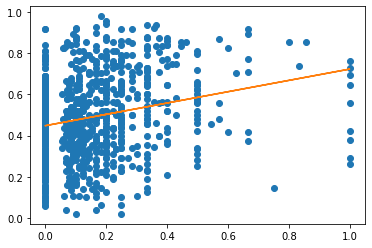

In [137]:
plt.plot(lexicon_train[:,0], lexicon_train[:,1], 'o')
plt.plot(lexicon_train[:,0], m*lexicon_train[:,0] + b)
plt.show()

## Deep Learning Models

### LSTM

In [138]:
model1 = Sequential()
model1.add(layers.Embedding(input_dim=vocab_size, output_dim=emdedding_size,weights=[pretrained_weights]))
model1.add(layers.LSTM(15,dropout=0.5)) #Our LSTM layer
model1.add(layers.Dense(3,activation='relu'))
model1.compile(optimizer='adam',loss='mse')

In [139]:
history = model1.fit(train_data, y_train, epochs=4,validation_data=(dev_data,y_dev))

Epoch 1/4
26/26 [==============================] - 204s 8s/step - loss: 0.1259 - val_loss: 0.0714
Epoch 2/4
26/26 [==============================] - 182s 7s/step - loss: 0.0464 - val_loss: 0.0537
Epoch 3/4
26/26 [==============================] - 163s 6s/step - loss: 0.0333 - val_loss: 0.0530
Epoch 4/4
26/26 [==============================] - 223s 9s/step - loss: 0.0265 - val_loss: 0.0556


In [ ]:
model1.save("/content/gdrive/MyDrive/EmoInt/joy/lstm_model")

In [ ]:
model1 = keras.models.load_model('/content/gdrive/MyDrive/EmoInt/joy/lstm_model')

In [140]:
y_pred = model1.predict(dev_data)

In [141]:
y_pred_5 = model1.predict(dev_data_5)

In [142]:
y_dev_5 = np.array(y_dev_5, dtype = float)

In [143]:
y_pred=y_pred[:,0].reshape(dev_data.shape[0],1)
y_pred_5=y_pred_5[:,0].reshape(dev_data_5.shape[0],1)
y_pred = np.squeeze(y_pred)
y_dev = np.squeeze(y_dev)
y_pred_5 = np.squeeze(y_pred_5)
y_dev_5 = np.squeeze(y_dev_5)

In [144]:
[pears_corr3,spear_corr3,pears_corr_range_05_13,spear_corr_range_05_13]=evaluate(y_pred,y_dev,y_pred_5,y_dev_5)
print('Pearsons correlation for gold score:'+str(pears_corr3))
print('Spearmans correlation for gold score:'+str(spear_corr3))
print('Pearsons correlation for gold score for gold score greater than 0.5:'+str(pears_corr_range_05_13))
print('Spearmans correlation for gold score for gold score greater than 0.5:'+str(spear_corr_range_05_13))

Pearsons correlation for gold score:0.053581287295951886
Spearmans correlation for gold score:0.07506376188490552
Pearsons correlation for gold score for gold score greater than 0.5:0.030194985898706457
Spearmans correlation for gold score for gold score greater than 0.5:0.00040528925109670195


### Bidirectional LSTM

In [117]:
model2 = Sequential()
model2.add(layers.Embedding(input_dim=vocab_size, output_dim=emdedding_size,weights=[pretrained_weights]))
model2.add(layers.Bidirectional(layers.LSTM(20,dropout=0.6)))
model2.add(layers.Dense(3,activation='relu'))
model2.compile(optimizer='adam',loss='mse',)

In [118]:
history2 = model2.fit(train_data, y_train, epochs=5,validation_data=(dev_data,y_dev))

Epoch 1/5
26/26 [==============================] - 233s 9s/step - loss: 0.1095 - val_loss: 0.0593
Epoch 2/5
26/26 [==============================] - 217s 8s/step - loss: 0.0420 - val_loss: 0.0533
Epoch 3/5
26/26 [==============================] - 216s 8s/step - loss: 0.0343 - val_loss: 0.0557
Epoch 4/5
26/26 [==============================] - 230s 9s/step - loss: 0.0276 - val_loss: 0.0525
Epoch 5/5
26/26 [==============================] - 247s 10s/step - loss: 0.0215 - val_loss: 0.0586


In [ ]:
model2.save("/content/gdrive/MyDrive/EmoInt/joy/bidirectional_lstm_model")

In [ ]:
model2 = keras.models.load_model('/content/gdrive/MyDrive/EmoInt/joy/bidirectional_lstm_model')

In [119]:
y_pred = model2.predict(dev_data)

In [120]:
y_pred_5 = model2.predict(dev_data_5)

In [121]:
y_pred=y_pred[:,0].reshape(dev_data.shape[0],1)
y_pred_5=y_pred_5[:,0].reshape(dev_data_5.shape[0],1)
y_pred = np.squeeze(y_pred)
y_dev = np.squeeze(y_dev)
y_pred_5 = np.squeeze(y_pred_5)
y_dev_5 = np.squeeze(y_dev_5)

In [122]:
[pears_corr4,spear_corr4,pears_corr_range_05_14,spear_corr_range_05_14]=evaluate(y_pred,y_dev,y_pred_5,y_dev_5)
print('Pearsons correlation for gold score:'+str(pears_corr4))
print('Spearmans correlation for gold score:'+str(spear_corr4))
print('Pearsons correlation for gold score for gold score greater than 0.5:'+str(pears_corr_range_05_14))
print('Spearmans correlation for gold score for gold score greater than 0.5:'+str(spear_corr_range_05_14))

Pearsons correlation for gold score:0.04782371672627958
Spearmans correlation for gold score:0.05674216577125277
Pearsons correlation for gold score for gold score greater than 0.5:0.018670949515689886
Spearmans correlation for gold score for gold score greater than 0.5:0.04417652836954051


###1-D Conv Net

In [118]:
model3 = Sequential()
model3.add(layers.Embedding(input_dim=vocab_size, output_dim=emdedding_size,weights=[pretrained_weights]))
model3.add(layers.Conv1D(filters=32, kernel_size=8, activation='relu'))
model3.add(layers.MaxPooling1D(pool_size=2))
model3.add(layers.GlobalMaxPooling1D())
model3.add(layers.Dense(1, activation='relu'))
model3.compile(optimizer='adam',loss='mse')

In [119]:
history3 = model3.fit(train_data, y_train, epochs=5,validation_data=(dev_data,y_dev))

Epoch 1/5
26/26 [==============================] - 210s 8s/step - loss: 0.0863 - val_loss: 0.0729
Epoch 2/5
26/26 [==============================] - 191s 7s/step - loss: 0.0406 - val_loss: 0.0628
Epoch 3/5
26/26 [==============================] - 200s 8s/step - loss: 0.0218 - val_loss: 0.0552
Epoch 4/5
26/26 [==============================] - 205s 8s/step - loss: 0.0162 - val_loss: 0.0553
Epoch 5/5
26/26 [==============================] - 235s 9s/step - loss: 0.0139 - val_loss: 0.0556


In [ ]:
model3.save("/content/gdrive/MyDrive/EmoInt/joy/1ConvNet_model")

In [ ]:
model3 = keras.models.load_model('/content/gdrive/MyDrive/EmoInt/joy/1ConvNet_model')

In [120]:
y_pred = model3.predict(dev_data)

In [121]:
y_pred_5 = model3.predict(dev_data_5)

In [122]:
y_pred=y_pred[:,0].reshape(dev_data.shape[0],1)
y_pred_5=y_pred_5[:,0].reshape(dev_data_5.shape[0],1)
y_pred = np.squeeze(y_pred)
y_dev = np.squeeze(y_dev)
y_pred_5 = np.squeeze(y_pred_5)
y_dev_5 = np.squeeze(y_dev_5)

In [123]:
[pears_corr5,spear_corr5,pears_corr_range_05_15,spear_corr_range_05_15]=evaluate(y_pred,y_dev,y_pred_5,y_dev_5)
print('Pearsons correlation for gold score:'+str(pears_corr5))
print('Spearmans correlation for gold score:'+str(spear_corr5))
print('Pearsons correlation for gold score for gold score greater than 0.5:'+str(pears_corr_range_05_15))
print('Spearmans correlation for gold score for gold score greater than 0.5:'+str(spear_corr_range_05_15))

Pearsons correlation for gold score:0.13371055335864887
Spearmans correlation for gold score:0.12338239645814773
Pearsons correlation for gold score for gold score greater than 0.5:0.36350926523757837
Spearmans correlation for gold score for gold score greater than 0.5:0.3645576813614834
